# 03 - Normal vs. Isolate vs. Deaf

## Imports

In [1]:
import avn.dataloading as dataloading
import avn.acoustics as acoustics
import avn.plotting as plotting
import avn.segmentation as segmentation
import avn.syntax as syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import librosa
import os

from numpy.fft import fft, fftfreq
from scipy.signal.windows import hann
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load Normal and Iso Dataset

In [2]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

In [4]:
all_feats_normal.columns.to_frame().to_csv('LDA Features Table.csv')

In [5]:
all_feats_normal = all_feats_normal[all_feats_normal.Bird_ID != 'S389']

Let's drop the Duke deaf and control birds

In [6]:
all_feats_normal = all_feats_normal[~all_feats_normal.Condition.isin(['pre-deafening', 'post-deafening'])]
all_feats_normal.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil'], dtype=object)

## Load Wada Lab Deaf Birds

In [7]:
all_feats_deaf = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\wada_birds_all_feats.csv').drop(columns = 'Unnamed: 0')

In [8]:
all_feats_deaf

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length,Condition
0,0.117747,0.114967,0.121071,2155.357576,2109.599981,2867.423096,-3.266155,-3.448087,-3.060742,61.694346,...,-0.142866,6.848818,0.795698,0.679239,2.085816,0.695272,7,1.180929,0.341734,deaf_120
1,0.138719,0.134799,0.143075,1916.063608,1905.271892,1967.627065,-3.067501,-3.118677,-2.831167,60.048020,...,-0.420613,4.462123,0.623511,0.596916,1.073634,0.415338,5,6.325758,0.855042,deaf_300
2,0.120487,0.115469,0.141427,1761.408783,1563.806841,3297.943880,-3.145204,-3.359798,-2.939603,56.802061,...,-0.186091,4.453035,0.661636,0.792669,2.322015,0.671213,10,2.047170,0.529954,deaf_120
3,0.138086,0.123512,0.146133,1756.748116,1433.786306,2007.303591,-3.356677,-3.532446,-2.834024,56.994473,...,-0.890552,4.523146,0.439880,0.786990,1.312251,0.413969,8,1.200000,0.381881,deaf_300
4,0.114786,0.104775,0.116830,1789.762898,1485.763158,2337.077138,-3.683179,-3.889325,-3.563164,54.013514,...,-0.229416,2.829038,0.684722,0.851385,2.736651,0.823814,9,1.807692,0.555234,deaf_120
5,0.140029,0.123126,0.163307,1837.666285,1569.842809,2464.989868,-2.950556,-3.258490,-2.657295,52.208152,...,-0.814188,3.042721,0.430952,0.581725,1.596453,0.503625,8,2.497939,0.711100,deaf_300
6,0.110085,0.102550,0.135041,2305.491632,1474.451575,3660.457968,-2.612077,-2.928364,-2.373068,52.716926,...,-0.145907,12.336573,0.740859,0.862666,2.236685,0.646547,10,1.750000,0.473804,deaf_120
7,0.131318,0.123017,0.143566,1944.922759,1834.077485,2438.096988,-2.865155,-3.101042,-2.670985,57.502545,...,-0.212056,4.376186,0.636782,0.828545,1.416925,0.504719,6,2.524590,0.623647,deaf_300
8,0.118705,0.113045,0.124365,1804.720076,1590.400913,2019.039239,-3.079158,-3.291822,-2.866493,49.660063,...,-0.176262,7.477644,0.593052,0.866371,0.778098,0.490925,2,5.219178,0.842512,deaf_120
9,0.170568,0.128027,0.179388,1705.981868,1661.570229,1956.193094,-3.513520,-3.598754,-3.245168,58.378313,...,-0.367510,4.838005,0.419097,0.669968,0.814732,0.350886,4,6.861111,0.639381,deaf_300


In [9]:
all_feats_deaf['rhythm_entropy'] = 10**all_feats_deaf.rhythm_entropy

## Merge Datasets

In [10]:
all_feats = pd.concat([all_feats_normal, all_feats_deaf])

In [11]:
all_feats = all_feats.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [12]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

## Normalize Dataset

In [13]:
features_only = all_feats.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

scaler = StandardScaler()
scaler.fit(feature_mat)

StandardScaler()

In [14]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil', 'deaf_120', 'deaf_300',
       'sham-deafening'], dtype=object)

In [15]:
normal_iso_deaf = all_feats[~all_feats.Condition.isin([ 'FP1_KD_pre_tut', 'deaf_120'])]

In [16]:
features_only = normal_iso_deaf.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [17]:
class_dict = {'sham-deafening' : 0, 
              'deaf_300' : 1, 
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_iso_deaf.Condition]

## L1-Based Feature Selection

In [18]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [19]:
print(feature_mat_norm.shape)
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model = SelectFromModel(lsvc, prefit=True)
x_new = model.transform(feature_mat_norm)
x_new.shape

(103, 43)


(103, 19)

Alright, so this cuts down our feature set from 43 to only 19 features. What are those features? 

In [20]:
feature_idx = [lsvc.coef_.sum(axis = 0) != 0]
features = features_only.columns[np.squeeze(feature_idx)]

In [21]:
features

Index(['Goodness_mean_median', 'Goodness_mean_min', 'Goodness_mean_max',
       'Mean_frequency_mean_max', 'Entropy_mean_median', 'Entropy_mean_min',
       'Entropy_mean_max', 'Frequency_modulation_mean_min', 'Pitch_mean_max',
       'duration_mean_min', 'Goodness_CV_median', 'Mean_frequency_CV_median',
       'Mean_frequency_CV_min', 'duration_CV_min', 'rhythm_entropy',
       'syllable_duration_entropy', 'syntax_entropy_rate',
       'mean_repetition_length', 'CV_repetition_length'],
      dtype='object')

In [22]:
lsvc.coef_.shape

(3, 43)

In [23]:
feature_weights = pd.DataFrame({'feature' : features_only.columns.values, 
                                'weight0' : lsvc.coef_[0],
                                'weight1' : lsvc.coef_[1], 
                                'weight2' : lsvc.coef_[2]})
feature_weights['abs_weight'] = np.abs(feature_weights.weight0) + np.abs(feature_weights.weight1) + np.abs(feature_weights.weight2)
feature_weights.sort_values('abs_weight', ascending=False).head(20)

,feature,weight0,weight1,weight2,abs_weight
40,syntax_entropy_rate,-0.241851,0.000000,0.284314,0.526165
34,duration_CV_min,-0.367657,0.028982,0.107422,0.504061
36,rhythm_entropy,-0.167384,0.000000,0.182844,0.350228
7,Entropy_mean_min,0.101031,0.000000,-0.174540,0.275571
5,Mean_frequency_mean_max,0.002008,-0.249789,0.000000,0.251797
22,Mean_frequency_CV_min,0.000000,0.162308,0.000000,0.162308
0,Goodness_mean_median,0.089367,0.000000,-0.021555,0.110922
1,Goodness_mean_min,0.029334,0.000000,-0.070118,0.099452
8,Entropy_mean_max,0.091460,0.000000,-0.001397,0.092857
38,syllable_duration_entropy,0.000000,0.000000,0.080713,0.080713


In [24]:
for_plotting = feature_weights.set_index('feature')
for_plotting = for_plotting.sort_values('abs_weight', ascending=False)
for_plotting = for_plotting[for_plotting.abs_weight != 0]

In [25]:
plt.rcParams.update({'font.size': 8})

Text(-1.184027777777791, 0.5, '')

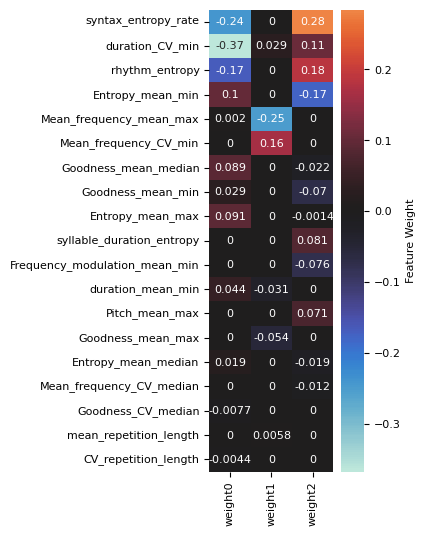

In [26]:
plt.figure(figsize = (2, 6))
sns.heatmap(for_plotting.drop(columns = 'abs_weight'), annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'} )
plt.ylabel('')

weight 0 reflects typical vs. rest, weight 1 reflects deaf vs. rest, and weight 2 reflects isolate vs. rest. 

In [27]:
for_plotting = for_plotting.rename(columns = {'weight0' : 'Typical', 
                                              'weight1' : 'Deaf', 
                                              'weight2' : 'Isolate'})

Text(0.5, 1.0, 'Typical vs. Deaf vs. Isolate Feature Weights')

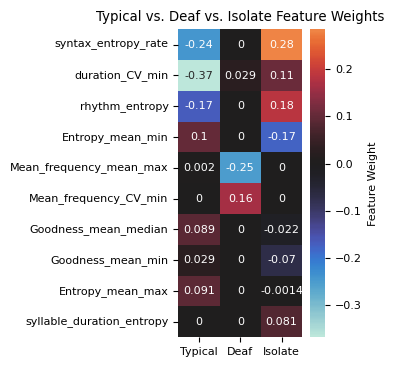

In [30]:
plt.figure(figsize = (2, 4))
sns.heatmap(for_plotting.drop(columns = 'abs_weight').iloc[:10], annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'} )
plt.ylabel('')
plt.title('Typical vs. Deaf vs. Isolate Feature Weights')

Text(0.5, 1.0, 'Typical vs. Deaf vs. Isolate Feature Weights')

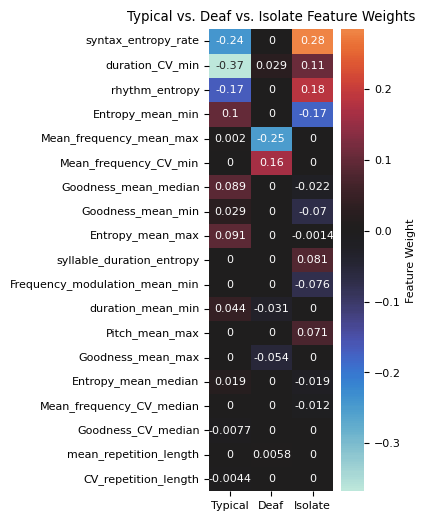

In [32]:
plt.figure(figsize = (2, 6))
sns.heatmap(for_plotting.drop(columns = 'abs_weight'), annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'} )
plt.ylabel('')
plt.title('Typical vs. Deaf vs. Isolate Feature Weights')

## Classification Without FP1 Birds

In [65]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

In [66]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats = 10, random_state=42)
scores = cross_val_score(model, X = x_new, y = y, scoring = 'accuracy', cv = cv, )

In [67]:
scores.mean()

0.9303333333333336

In [68]:
sem(scores)

0.006869000249106958

## Classification with FP1 Birds

In [69]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil', 'deaf_120', 'deaf_300',
       'sham-deafening'], dtype=object)

In [70]:
normal_and_deaf_fp1 = all_feats[~all_feats.Condition.isin(['deaf_120'])]

In [71]:
features_only = normal_and_deaf_fp1.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm_fp1 = scaler.transform(feature_mat)

In [72]:
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model = SelectFromModel(lsvc, prefit=True)
x_new = model.transform(feature_mat_norm)
x_new_fp1 = model.transform(feature_mat_norm_fp1)

In [74]:
feature_idx = [lsvc.coef_.sum(axis=0) != 0]
features = features_only.columns[np.squeeze(feature_idx)]
len(features)

19

In [75]:
#fit model with dataset of only normal and deaf
model = LinearDiscriminantAnalysis()
model.fit(x_new, y)
#transform dataset of normal, deaf + FP1 
X_transformed = model.transform(x_new_fp1)
X_transformed.shape

(110, 2)

In [76]:
lda_df = pd.DataFrame({'coord_x' : X_transformed[:, 0],
                       'coord_y' : X_transformed[:, 1], 
                        'condition' : normal_and_deaf_fp1.Condition, 
                         'Bird_ID' : normal_and_deaf_fp1.Bird_ID})

In [92]:
group_dict = {'deaf_300' : "Deaf", 
              'sham-deafening' : "Typical", 
              'deaf_120' : "Deaf Unstable",
              'FP1_KD_post_tut' : 'Typical', 
              'GFP' : 'Typical', 
              'Pupil' :  'Typical', 
              'Tutor' : 'Typical', 
              'Rockefeller-Pupil': 'Typical',
              'Isolate' : 'Isolate', 
              'FP1_KD_pre_tut' : 'FP1 KD'}
lda_df['Group'] = [group_dict[x] for x in lda_df.condition]

Text(0.5, 1.0, 'Typical vs. Isolate vs. Deaf LDA')

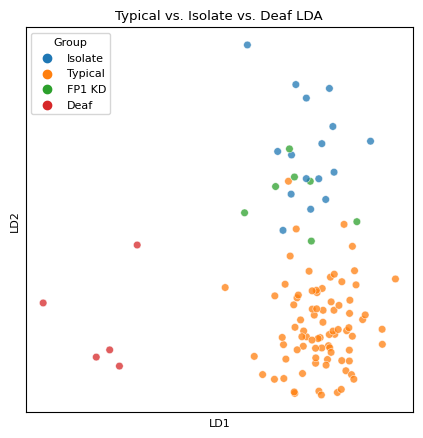

In [94]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data = lda_df[lda_df.Group != 'Deaf Unstable'], x = 'coord_x', y ='coord_y', hue = 'Group', alpha = 0.75, s = 30)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.xticks([])
plt.yticks([])
plt.title('Typical vs. Isolate vs. Deaf LDA')

### Classification Confusion Matrix

#### LOO cross validation on all but FP1

In [156]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix

In [157]:
class_dict = {'deaf_300' : 1, 
              'sham-deafening' : 0, 
              'deaf_120' : 4,
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_iso_deaf.Condition]

In [158]:
y = np.array(y)

In [159]:
y.shape

(103,)

In [160]:
x_new.shape

(103, 19)

In [161]:
# Initialize the LDA model
model = LinearDiscriminantAnalysis()

# Set up the leave-one-out cross-validation
loo = LeaveOneOut()

# Lists to store true labels and predictions
y_true, y_pred = [], []

# Iterate over each train/test split
for train_index, test_index in loo.split(x_new):
    # Split the data
    X_train, X_test = x_new[train_index], x_new[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model on the training set
    model.fit(X_train, y_train)
    
    # Predict on the test set
    prediction = model.predict(X_test)
    
    # Store true labels and predictions
    y_true.append(y_test[0])
    y_pred.append(prediction[0])

#### Predict FP1 Birds

In [162]:
#fit model with dataset of only normal, deaf and isolate
model = LinearDiscriminantAnalysis()
model.fit(x_new, y)

LinearDiscriminantAnalysis()

In [163]:
#predict dataset of normal, deaf, isolate + FP1 
y_pred_fp1 = model.predict(x_new_fp1)

#select only predictions of FP1. The rest will be from the LOO
y_pred_fp1 = y_pred_fp1[normal_and_deaf_fp1.Condition == 'FP1_KD_pre_tut']

y_true_fp1 = np.ones_like(y_pred_fp1) * 3

In [164]:
type(y_true_fp1)

numpy.ndarray

In [165]:
y_true = np.concatenate((np.array(y_true), y_true_fp1))
y_pred = np.concatenate((np.array(y_pred), y_pred_fp1))

In [166]:
conf_mat = confusion_matrix(y_true, y_pred)

In [167]:
row_sums = conf_mat.sum(axis = 1, keepdims=True)
norm_mean_conf_mat = conf_mat/row_sums

In [171]:
conf_mat = pd.DataFrame(norm_mean_conf_mat, columns = ['Typical', 'Deaf', 'Isolate', 'FP1 KD'], index = ['Typical', 'Deaf', 'Isolate', 'FP1 KD'])
conf_mat = conf_mat.drop(columns = 'FP1 KD')

In [178]:
plt.rcParams.update({'font.size': 11})

Text(0.5, 1.0, 'Normal vs. Isolate vs. Deaf Confusion Matrix')

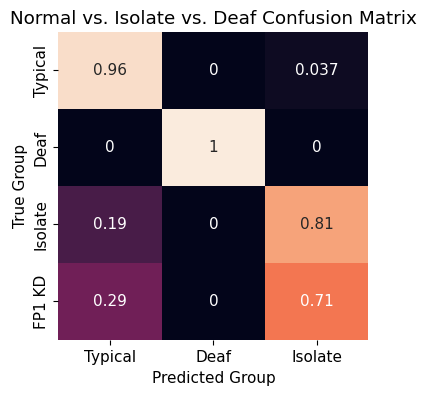

In [180]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_mat, annot = True, cbar=False)
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('Normal vs. Isolate vs. Deaf Confusion Matrix')